In [1]:
import os
from PIL import Image
%matplotlib inline

In [2]:
dataset_dir = './semantic_drone_dataset'
original_images = os.path.join(dataset_dir,'original_images')
semantic_labels = os.path.join(dataset_dir,'label_images_semantic')

In [3]:
list_original_images = os.listdir(original_images)
list_semantic_images = os.listdir(semantic_labels)

In [4]:
list_original_images.sort()
list_semantic_images.sort()

In [5]:
image_dir = os.path.join(original_images, list_original_images[0])
semantic_image_dir = os.path.join(semantic_labels, list_semantic_images[0])

In [6]:
import matplotlib.pyplot as plt
image = Image.open(image_dir)
semantic_image = Image.open(semantic_image_dir)
semantic_image_a = plt.imread(semantic_image_dir)

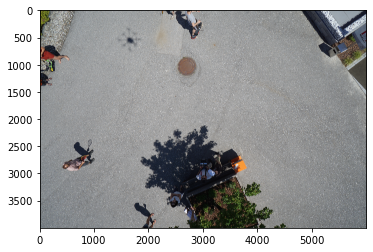

In [7]:
plt.imshow(image)

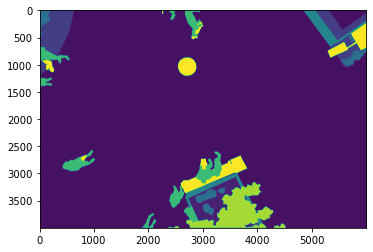

In [8]:
plt.imshow(semantic_image)

In [9]:
import torch
from utils import UNet,DroneDataset,Segnet
from torch.utils.data import DataLoader
import hyperparmeters

In [13]:
model = UNet(23)

In [15]:
PATH = './Unet_1.pth'
model_config = torch.load(PATH)

In [16]:
model_config

{'state_dict': OrderedDict([('encoder1.encode.0.weight',
               tensor([[[[ 0.1599,  0.0308, -0.1219],
                         [-0.1718, -0.1984, -0.2583],
                         [ 0.1119,  0.4262, -0.0547]],
               
                        [[-0.4429,  0.3900,  0.0495],
                         [-0.2867, -0.0980,  0.0271],
                         [-0.1676,  0.0898,  0.4193]],
               
                        [[ 0.0165,  0.3087, -0.2107],
                         [ 0.1250,  0.3718, -0.2461],
                         [-0.4127,  0.0607,  0.1247]]],
               
               
                       [[[ 0.0140, -0.1509,  0.1408],
                         [ 0.3221,  0.0849, -0.2054],
                         [-0.1365,  0.1790,  0.0306]],
               
                        [[ 0.0548, -0.2723, -0.3011],
                         [ 0.3477,  0.1226, -0.1330],
                         [-0.2983,  0.0984,  0.1197]],
               
                        [[-0.09

In [17]:
model.load_state_dict(model_config['state_dict'])

<All keys matched successfully>

In [18]:
def get_data_loader():
    """Function to return Data Loader"""
    X = list(os.listdir('./semantic_drone_dataset/original_images'))
    X = [i.strip('.jpg') for i in X]
    dataset = DroneDataset(img_path='./semantic_drone_dataset/original_images', mask_path='./semantic_drone_dataset/label_images_semantic',
                           X = X, mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

    train_loader = DataLoader(dataset, batch_size=8)
    return train_loader

In [19]:
data_loader = get_data_loader()

In [20]:
it = iter(data_loader)

In [21]:
images, masks = it.next()

In [22]:
images = images.cuda()
masks = masks.cuda()
model.cuda()

UNet(
  (encoder1): Unet_EncoderBlock(
    (encode): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (encoder2): Unet_EncoderBlock(
    (encode): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, pa

In [23]:
predicted_mask = model(images)

/home/rachit/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/rachit/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [24]:
predicted_mask.shape

torch.Size([8, 23, 224, 224])

In [25]:
import torch.nn.functional as F
predicted_mask = F.log_softmax(predicted_mask, dim =1)

In [26]:
predicted_mask = torch.argmax(predicted_mask, dim =1 )

In [27]:
predicted_mask.shape

torch.Size([8, 224, 224])

In [28]:
masks = masks.cpu()
predicted_mask = predicted_mask.cpu()

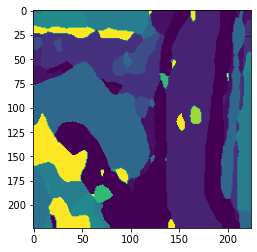

In [29]:
plt.imshow(predicted_mask[0])

In [30]:
plt.imsave('./Unet_1.png',predicted_mask[0])

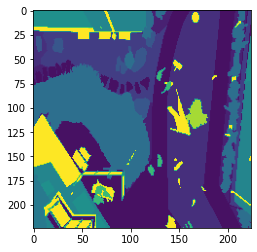

In [31]:
plt.imshow(masks[0])

In [32]:
epochs = model_config['epochs']
losses = model_config['losses']